In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [32]:
# 1. CARREGAR OS DADOS
# Substitua 'seu_arquivo.csv' pelo caminho do seu arquivo
# Passo 1: Carregar dados
caminho = r"F:\Eleições 2024\province_day.csv"
df = pd.read_csv(caminho, encoding='utf-8')

In [92]:
from jupyter_dash import JupyterDash
app = JupyterDash(__name__)
app.run_server(mode="inline")


C:\Users\neves\anaconda3\lib\site-packages\dash\dash.py:642: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



AttributeError: 'super' object has no attribute 'run_server'

In [33]:
df

,province,date,registered_cases_per_day,registered_cases,incident_type,phase,stage,target_incident
0,cabo delgado,2024-04-12,23.000000,23,"baleamentos, mortes",4 fase,4 etapa,1
1,cabo delgado,2024-10-21,3.200000,16,detencoes,1 - 2 fase,NaN,1
2,cabo delgado,2024-10-22,3.200000,16,detencoes,1 - 2 fase,NaN,1
3,cabo delgado,2024-10-23,3.200000,16,detencoes,1 - 2 fase,NaN,1
4,cabo delgado,2024-10-24,3.200000,16,detencoes,1 - 2 fase,NaN,1
...,...,...,...,...,...,...,...,...
409,zambezia,2024-12-25,4.000000,4,"baleamentos, detencoes, mortes",v8,NaN,1
410,zambezia,2024-12-26,1.000000,1,"baleamentos, detencoes, mortes",v8,NaN,1
411,zambezia,2024-12-27,6.333333,19,"baleamentos, detencoes, mortes",v8,NaN,1
412,zambezia,2024-12-28,6.333333,19,"baleamentos, detencoes, mortes",v8,NaN,1


In [96]:
df.head

<bound method NDFrame.head of          province       date  registered_cases_per_day  registered_cases  \
0    cabo delgado 2024-04-12                 23.000000                23   
1    cabo delgado 2024-10-21                  3.200000                16   
2    cabo delgado 2024-10-22                  3.200000                16   
3    cabo delgado 2024-10-23                  3.200000                16   
4    cabo delgado 2024-10-24                  3.200000                16   
..            ...        ...                       ...               ...   
409      zambezia 2024-12-25                  4.000000                 4   
410      zambezia 2024-12-26                  1.000000                 1   
411      zambezia 2024-12-27                  6.333333                19   
412      zambezia 2024-12-28                  6.333333                19   
413      zambezia 2024-12-29                  6.333333                19   

                      incident_type       phase    stage 

In [49]:

# 1) Normalizar colunas
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['province'] = df['province'].str.strip().str.lower()
df['incident_type'] = df['incident_type'].fillna('').str.lower().str.replace('"','').str.strip()

# 2) Remover outlier (Luanda)
df = df[df['province'] != 'luanda']

# 3) Criar variáveis binárias por tipo
tipos = ['baleamentos', 'detencoes', 'mortes']
for t in tipos:
    df[f'{t}_ocorreu'] = df['incident_type'].str.contains(t).astype(int)

# 4) Criar variáveis de contagem (proxy inicial: presença = 1, ausência = 0)
for t in tipos:
    df[f'n_{t}'] = df[f'{t}_ocorreu']

# 5) Features temporais
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# 6) Criar lags (memória curta)
lags = [1, 3, 7]
for t in tipos:
    for L in lags:
        df[f'{t}_lag{L}'] = df.groupby('province')[f'{t}_ocorreu'].shift(L)
        df[f'n_{t}_lag{L}'] = df.groupby('province')[f'n_{t}'].shift(L)

# 7) Alvo global de incidente (amanhã)
df['incident_tomorrow'] = df.groupby('province')['target_incident'].shift(-1)

# Visualizar primeiras linhas
print(df.head(10))


       province       date  registered_cases_per_day  registered_cases  \
0  cabo delgado 2024-04-12                      23.0                23   
1  cabo delgado 2024-10-21                       3.2                16   
2  cabo delgado 2024-10-22                       3.2                16   
3  cabo delgado 2024-10-23                       3.2                16   
4  cabo delgado 2024-10-24                       3.2                16   
5  cabo delgado 2024-10-25                       3.2                16   
6  cabo delgado 2024-11-15                       1.0                 1   
7  cabo delgado 2024-11-16                       0.0                 0   
8  cabo delgado 2024-11-17                       0.0                 0   
9  cabo delgado 2024-11-18                       0.0                 0   

         incident_type       phase    stage  target_incident  \
0  baleamentos, mortes      4 fase  4 etapa                1   
1            detencoes  1 - 2 fase      NaN              

In [53]:
# Totais por província em 2024
totais = df[df['date'].dt.year == 2024] \
            .groupby('province')[['baleamentos_ocorreu','detencoes_ocorreu','mortes_ocorreu']] \
            .sum()

print(totais)


                  baleamentos_ocorreu  detencoes_ocorreu  mortes_ocorreu
province                                                                
cabo delgado                       18                 30              16
gaza                               17                 36              11
inhambane                          24                 35              13
manica                             22                 38              25
maputo cidade                      27                 39              26
maputo provincia                   36                 39              35
nampula                            35                 41              41
niassa                              8                 14               1
sofala                             18                 38              18
tete                               15                 41              15
zambezia                           34                 22              33


In [55]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features e alvo
features = ['province','phase','stage','month','dayofweek'] + \
           [f'{t}_lag{L}' for t in ['baleamentos','detencoes','mortes'] for L in [1,3,7]] + \
           [f'n_{t}_lag{L}' for t in ['baleamentos','detencoes','mortes'] for L in [1,3,7]]

X = clf_df[features]
y = clf_df[[f'{t}_tomorrow' for t in ['baleamentos','detencoes','mortes']]]

# Pré-processamento
cat_cols = ['province','phase','stage']
num_cols = [c for c in X.columns if c not in cat_cols]

pre = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols),
    ('num', SimpleImputer(strategy='constant', fill_value=0), num_cols)
])

# Modelo
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
pipe = Pipeline([('pre', pre), ('model', MultiOutputClassifier(rf))])

# Split temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Treinar
pipe.fit(X_train, y_train)

# Avaliar
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.870     0.855     0.862        55
           1      0.850     0.986     0.913        69
           2      0.857     0.889     0.873        54

   micro avg      0.858     0.916     0.886       178
   macro avg      0.859     0.910     0.883       178
weighted avg      0.858     0.916     0.885       178
 samples avg      0.870     0.918     0.866       178



In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1) Criar alvos de contagem para amanhã
for t in ['baleamentos','detencoes','mortes']:
    df[f'n_{t}_tomorrow'] = df.groupby('province')[f'n_{t}'].shift(-1)

# Remover linhas sem alvo
reg_df = df.dropna(subset=[f'n_{t}_tomorrow' for t in ['baleamentos','detencoes','mortes']])

Xr = reg_df[features]

# 2) Treinar regressão por tipo
results = {}
for t in ['baleamentos','detencoes','mortes']:
    yr = reg_df[f'n_{t}_tomorrow']
    
    # Split temporal
    X_train, X_test, y_train, y_test = train_test_split(Xr, yr, test_size=0.2, shuffle=False)
    
    rf_reg = Pipeline([
        ('pre', pre),
        ('model', RandomForestRegressor(n_estimators=400, random_state=42))
    ])
    
    rf_reg.fit(X_train, y_train)
    pred = rf_reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    results[t] = {'MAE': mae, 'RMSE': rmse}
    print(f"{t}: MAE={mae:.3f}, RMSE={rmse:.3f}")


baleamentos: MAE=0.164, RMSE=0.334
detencoes: MAE=0.154, RMSE=0.356
mortes: MAE=0.186, RMSE=0.335


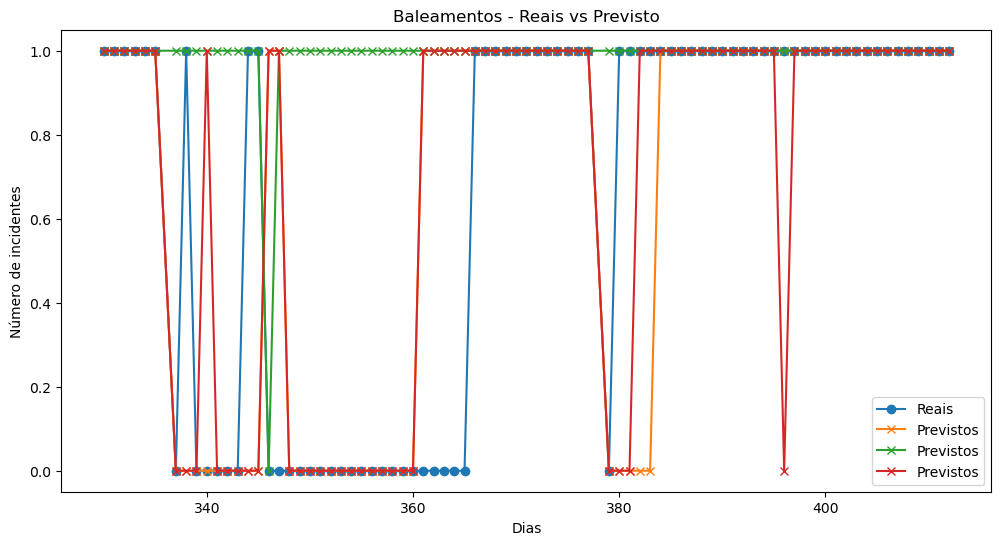

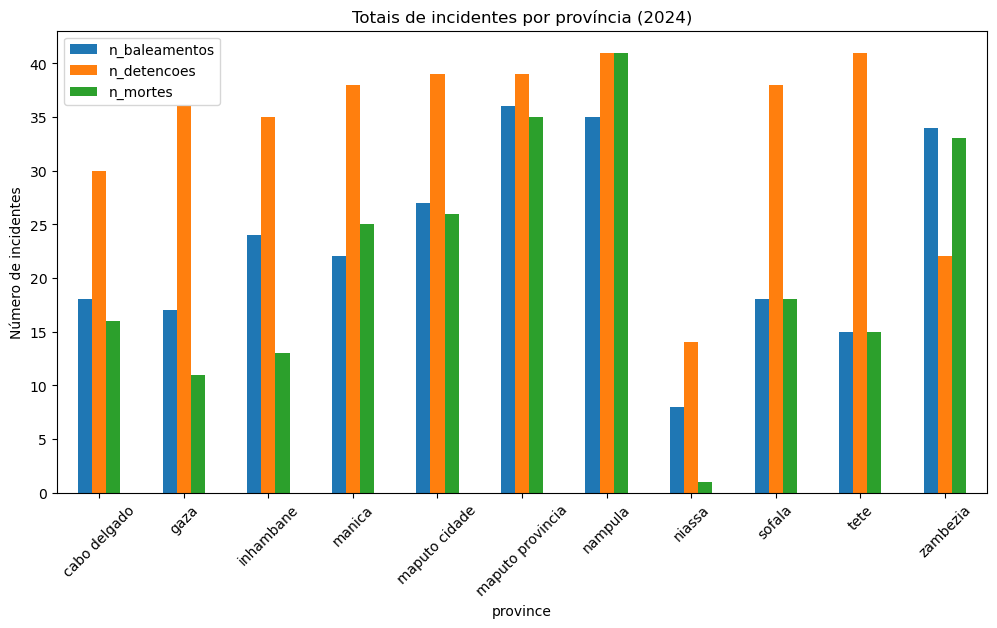

In [57]:
import matplotlib.pyplot as plt

# Exemplo: comparar valores reais vs previstos para baleamentos
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Reais", marker='o')
plt.plot(y_test.index, y_pred, label="Previstos", marker='x')
plt.title("Baleamentos - Reais vs Previsto")
plt.xlabel("Dias")
plt.ylabel("Número de incidentes")
plt.legend()
plt.show()

# Gráfico de barras por província (totais em 2024)
totais = df[df['date'].dt.year == 2024].groupby('province')[['n_baleamentos','n_detencoes','n_mortes']].sum()
totais.plot(kind='bar', figsize=(12,6))
plt.title("Totais de incidentes por província (2024)")
plt.ylabel("Número de incidentes")
plt.xticks(rotation=45)
plt.show()


In [63]:
import joblib

# Salvar o modelo treinado
joblib.dump(pipe, "modelo_incidentes.pkl")

# Se tiveres um pré-processador separado
joblib.dump(pre, "preprocessor.pkl")

['preprocessor.pkl']

In [64]:
import os
print(os.getcwd())   # mostra o diretório atual
print(os.listdir())  # lista os ficheiros disponíveis

C:\Users\neves
['-1.14-windows.xml', '.git', '.ipynb_checkpoints', '.ipython', '.jupyter', '.lesshst', '.matplotlib', '.vscode', '41-Cap05.zip', 'anaconda3', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'Definições Locais', 'Desafio DataWave.ipynb', 'Desafio_Datawave.ipynb', 'Desktop', 'Documents', 'Downloads', 'DSA-Python-Cap05-05-Metodos[1].ipynb', 'DSA-Python-Cap05-06-Funcoes[1].ipynb', 'DSA-Python-Cap05-07-Lambda[1].ipynb', 'DSA-Python-Cap05-08-List-Comprehension[1].ipynb', 'DSA-Python-Cap06-01-Arquivos[1].ipynb', 'DSA-Python-Cap06-02-TXT-CSV-JSON.ipynb', 'DSA-Python-Cap06-03-Modulos-e-Pacotes.ipynb', 'DSA-Python-Cap06-04-Map.ipynb', 'DSA-Python-Cap06-05-Reduce.ipynb', 'DSA-Python-Cap06-06-Filter.ipynb', 'DSA-Python-Cap06-07-Zip.ipynb', 'DSA-Python-Cap06-08-Enumerate.ipynb', 'DSA-Python-Cap08-01-Classes.ipynb', 'DSA-Python-Cap08-02-Objetos.ipynb', 'DSA-Python-Cap08-03-Metodos.ipynb', 'DSA-Python-Cap08-04-Heranca.ipynb', 'DSA-Python-Cap08-Exercicios-Solucao.ipynb', 'DSA-Pyt

In [71]:
rf_model = joblib.load("modelo_incidentes.pkl")
preprocessor = joblib.load("preprocessor.pkl")

In [72]:
!pip install dash

In [73]:
import dash
print(dash.__version__)

3.3.0


In [ ]:
# Instalar Prophet (se ainda não estiver instalado)
# !pip install prophet

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1) Preparar dados (exemplo: baleamentos totais por dia)
# Certifica-te que tens a coluna 'date' em formato datetime e 'n_baleamentos' como contagem
df['date'] = pd.to_datetime(df['date'])
df_prophet = df.groupby('date')['n_baleamentos'].sum().reset_index()
df_prophet.columns = ['ds','y']  # Prophet exige colunas ds (data) e y (valor)

# 2) Criar e treinar modelo
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)

# 3) Criar horizonte de 5 anos (365*5 dias)
future = model.make_future_dataframe(periods=5*365, freq='D')
forecast = model.predict(future)

# 4) Visualizar previsão
fig1 = model.plot(forecast)
plt.title("Previsão de Baleamentos para 5 anos")
plt.show()

# 5) Componentes (tendência e sazonalidade)
fig2 = model.plot_components(forecast)
plt.show()



C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


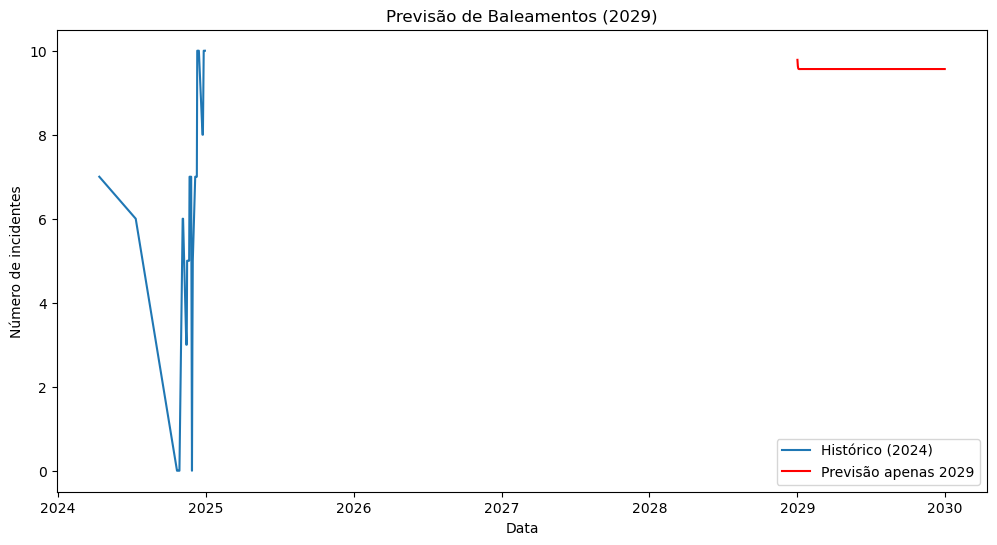

C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


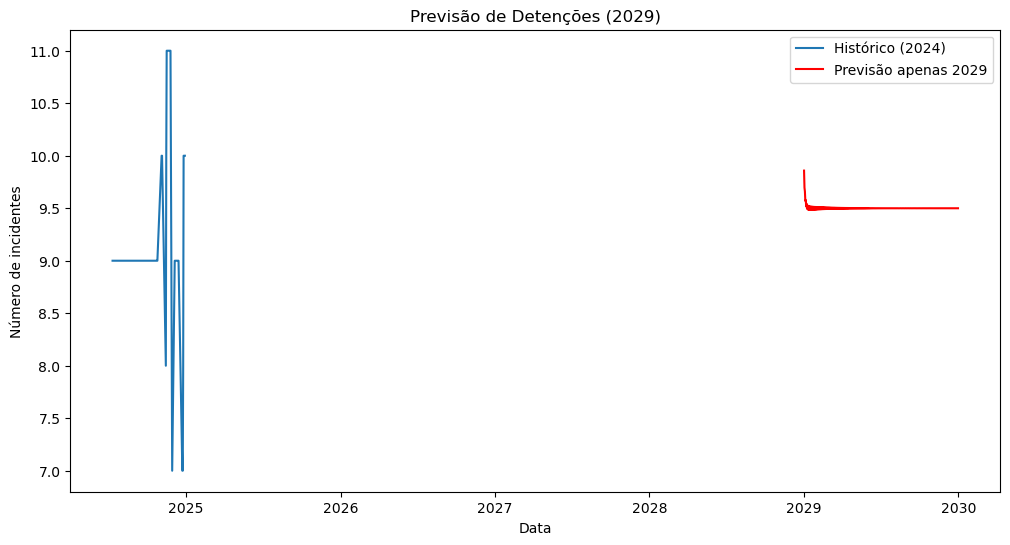

C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neves\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


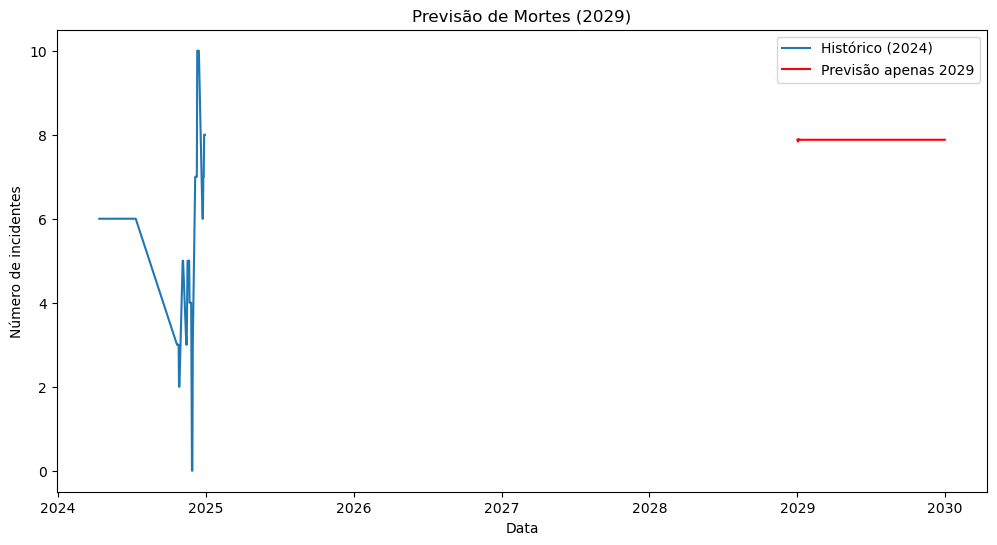

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assumindo que df já está carregado com dados desde 2004
df['date'] = pd.to_datetime(df['date'])

# 1) Filtrar apenas dados de 2024 (histórico)
df_2024 = df[df['date'].dt.year == 2024]

# 2) Tratar outliers (remoção simples usando IQR)
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[(series >= Q1 - 1.5*IQR) & (series <= Q3 + 1.5*IQR)]

# Função para prever apenas 2029
def prever_incidente(coluna, titulo):
    serie = df_2024.groupby('date')[coluna].sum()
    serie = remove_outliers(serie)  # remover outliers

    # Ajustar modelo ARIMA
    model = ARIMA(serie, order=(2,1,2))
    model_fit = model.fit()

    # Horizonte de previsão: apenas 2029
    future_dates = pd.date_range(start="2029-01-01", end="2029-12-31", freq="D")
    steps = len(future_dates)
    forecast = model_fit.forecast(steps=steps)

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(serie.index, serie.values, label="Histórico (2024)")
    plt.plot(future_dates, forecast, label="Previsão apenas 2029", color='red')
    plt.title(titulo)
    plt.xlabel("Data")
    plt.ylabel("Número de incidentes")
    plt.legend()
    plt.show()

# 3) Previsões em paralelo
prever_incidente("n_baleamentos", "Previsão de Baleamentos (2029)")
prever_incidente("n_detencoes", "Previsão de Detenções (2029)")
prever_incidente("n_mortes", "Previsão de Mortes (2029)")


In [90]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Preparar dados
df['date'] = pd.to_datetime(df['date'])
df_2024 = df[df['date'].dt.year == 2024]

# Função para prever 2029
def prever(coluna):
    serie = df_2024.groupby('date')[coluna].sum()
    model = ARIMA(serie, order=(2,1,2))
    model_fit = model.fit()
    future_dates = pd.date_range("2029-01-01","2029-12-31",freq="D")
    forecast = model_fit.forecast(steps=len(future_dates))
    return px.line(x=future_dates, y=forecast, title=f"Previsão de {coluna} em 2029")

# Criar app Dash
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Dashboard de Previsão 2029"),
    dcc.Dropdown(
        id='incidente',
        options=[
            {'label':'Baleamentos','value':'n_baleamentos'},
            {'label':'Detenções','value':'n_detencoes'},
            {'label':'Mortes','value':'n_mortes'}
        ],
        value='n_baleamentos'
    ),
    dcc.Graph(id='grafico')
])

@app.callback(
    dash.dependencies.Output('grafico','figure'),
    [dash.dependencies.Input('incidente','value')]
)
def atualizar(incidente):
    return prever(incidente)

if __name__ == '__main__':
    app.run(debug=True)   # ✅ substitui run_server por run


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

C:\Users\neves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [91]:
pip install jupyter-dash


Note: you may need to restart the kernel to use updated packages.


In [94]:
# Previsão nacional (sem província)
serie = df.groupby('date')['n_baleamentos'].sum()


In [95]:
for prov in df['province'].unique():
    serie = df_2024[df_2024['province'] == prov].groupby('date')['n_baleamentos'].sum()
